## Import Libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
train_url = 'data/train.csv'
test_url = 'data/test.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

train.head()

,id,Country,Year,Month,FoodPriceIndex
0,3501,Mexico,1971,11,0.0
1,60601,South Africa,2002,7,43.9
2,64399,Japan,2004,8,89.8
3,24227,France,1983,1,48.9
4,63779,Japan,2004,4,90.2


In [82]:
train.isna().sum().sort_values(ascending=False)

FoodPriceIndex    348
id                  0
Country             0
Year                0
Month               0
dtype: int64

In [83]:
test.isna().sum().sort_values(ascending=False)

id         0
Country    0
Year       0
Month      0
dtype: int64

In [84]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

Fill missing values with RFR

In [85]:
from sklearn.ensemble import RandomForestRegressor

# Split the data into training and prediction sets
train_data = train[train['FoodPriceIndex'].notnull()]
predict_data = train[train['FoodPriceIndex'].isnull()]

# Encode categorical variables
train_encoded = pd.get_dummies(train_data.drop(['FoodPriceIndex'], axis=1))
predict_encoded = pd.get_dummies(predict_data.drop('FoodPriceIndex', axis=1))

# Align the columns
train_encoded, predict_encoded = train_encoded.align(predict_encoded, join='left', axis=1, fill_value=0)

# Define features and target
X_train = train_encoded
y_train = train_data['FoodPriceIndex']
X_predict = predict_encoded

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Predict missing values
predicted = model.predict(X_predict)

# Fill the missing values
train.loc[train['FoodPriceIndex'].isnull(), 'FoodPriceIndex'] = predicted

In [86]:
train.isna().sum().sort_values(ascending=False)

Country           0
Year              0
Month             0
FoodPriceIndex    0
dtype: int64

In [87]:
len(train), len(test)

(11616, 2640)

In [88]:
train

,Country,Year,Month,FoodPriceIndex
0,Mexico,1971,11,0.0000
1,South Africa,2002,7,43.9000
2,Japan,2004,8,89.8000
3,France,1983,1,48.9000
4,Japan,2004,4,90.2000
...,...,...,...,...
11611,Sweden,1974,6,17.9000
11612,Germany,1987,4,66.1407
11613,Germany,1974,8,45.1606
11614,Denmark,1994,9,65.6000


In [89]:
# Create a 'Date' column
train['Date'] = pd.to_datetime(train['Year'].astype(str) + '-' + train['Month'].astype(str) + '-01')
# Extract time features
train['DayOfYear'] = train['Date'].dt.dayofyear
train['WeekOfYear'] = train['Date'].dt.isocalendar().week
train['Quarter'] = train['Date'].dt.quarter

In [90]:
train

,Country,Year,Month,FoodPriceIndex,Date,DayOfYear,WeekOfYear,Quarter
0,Mexico,1971,11,0.0000,1971-11-01,305,44,4
1,South Africa,2002,7,43.9000,2002-07-01,182,27,3
2,Japan,2004,8,89.8000,2004-08-01,214,31,3
3,France,1983,1,48.9000,1983-01-01,1,52,1
4,Japan,2004,4,90.2000,2004-04-01,92,14,2
...,...,...,...,...,...,...,...,...
11611,Sweden,1974,6,17.9000,1974-06-01,152,22,2
11612,Germany,1987,4,66.1407,1987-04-01,91,14,2
11613,Germany,1974,8,45.1606,1974-08-01,213,31,3
11614,Denmark,1994,9,65.6000,1994-09-01,244,35,3


In [91]:
# Cyclical encoding
train['Month_Sin'] = np.sin(2 * np.pi * train['Month'] / 12)
train['Month_Cos'] = np.cos(2 * np.pi * train['Month'] / 12)

# Lag feature for previous month
train['Lag_1'] = train.groupby('Country')['FoodPriceIndex'].shift(1)

# Rolling statistics
train['Rolling_Mean_3'] = train.groupby('Country')['FoodPriceIndex'].transform(lambda x: x.shift(1).rolling(window=3).mean())
train['Rolling_STD_3'] = train.groupby('Country')['FoodPriceIndex'].transform(lambda x: x.shift(1).rolling(window=3).std())

# Feature interactions
train['Year_Month'] = train['Year'] * train['Month']

In [95]:
train

,Country,Year,Month,FoodPriceIndex,Date,DayOfYear,WeekOfYear,Quarter,Month_Sin,Month_Cos,Lag_1,Rolling_Mean_3,Rolling_STD_3,Year_Month
0,Mexico,1971,11,0.0000,1971-11-01,305,44,4,-5.000000e-01,8.660254e-01,NaN,NaN,NaN,21681
1,South Africa,2002,7,43.9000,2002-07-01,182,27,3,-5.000000e-01,-8.660254e-01,NaN,NaN,NaN,14014
2,Japan,2004,8,89.8000,2004-08-01,214,31,3,-8.660254e-01,-5.000000e-01,NaN,NaN,NaN,16032
3,France,1983,1,48.9000,1983-01-01,1,52,1,5.000000e-01,8.660254e-01,NaN,NaN,NaN,1983
4,Japan,2004,4,90.2000,2004-04-01,92,14,2,8.660254e-01,-5.000000e-01,89.8000,NaN,NaN,8016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611,Sweden,1974,6,17.9000,1974-06-01,152,22,2,1.224647e-16,-1.000000e+00,75.0000,80.433333,11.187642,11844
11612,Germany,1987,4,66.1407,1987-04-01,91,14,2,8.660254e-01,-5.000000e-01,81.3921,72.279213,10.400360,7948
11613,Germany,1974,8,45.1606,1974-08-01,213,31,3,-8.660254e-01,-5.000000e-01,66.1407,74.009780,7.637343,15792
11614,Denmark,1994,9,65.6000,1994-09-01,244,35,3,-1.000000e+00,-1.836970e-16,70.6000,55.866667,19.540812,17946


<Axes: >

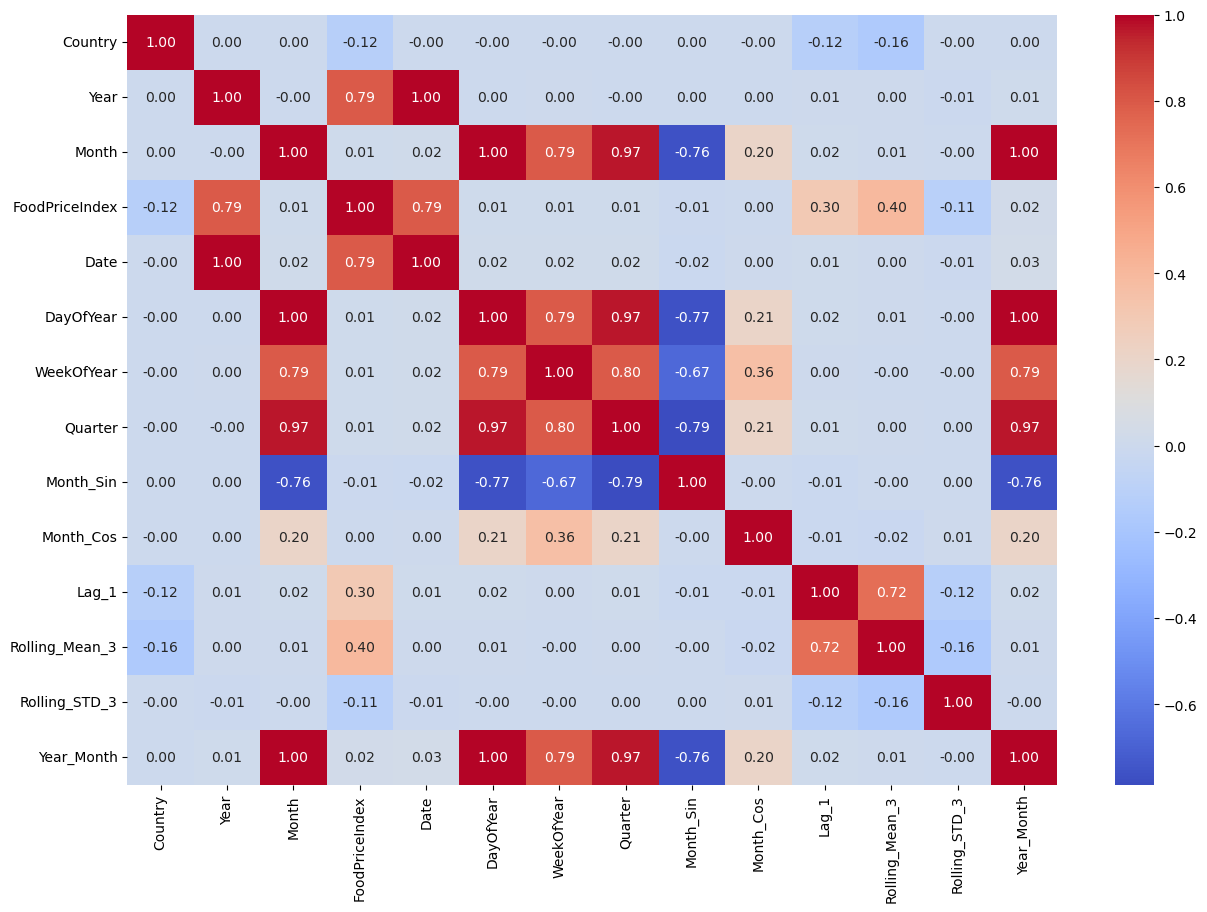

In [98]:
le = LabelEncoder()

train2 = train.copy()

train['Country'] = le.fit_transform(train['Country'])

plt.figure(figsize=(15, 10))

sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap='coolwarm')

In [99]:
train.isna().sum().sort_values(ascending=False)

Rolling_Mean_3    66
Rolling_STD_3     66
Lag_1             22
Country            0
Year               0
Month              0
FoodPriceIndex     0
Date               0
DayOfYear          0
WeekOfYear         0
Quarter            0
Month_Sin          0
Month_Cos          0
Year_Month         0
dtype: int64

array([[<Axes: title={'center': 'Rolling_Mean_3'}>,
        <Axes: title={'center': 'Rolling_STD_3'}>],
       [<Axes: title={'center': 'Lag_1'}>, <Axes: >]], dtype=object)

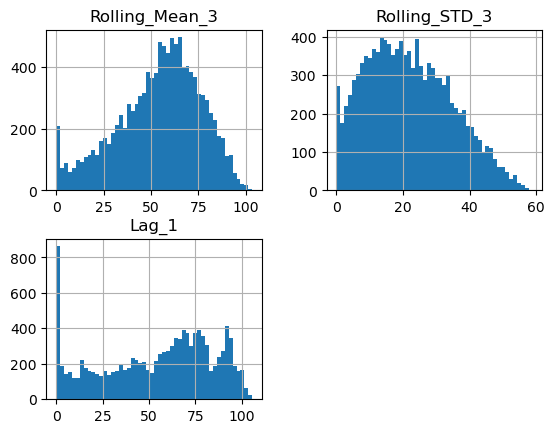

In [100]:
cols = ['Rolling_Mean_3', 'Rolling_STD_3', 'Lag_1']

train[cols].hist(bins=50)

array([[<Axes: title={'center': 'Rolling_Mean_3'}>,
        <Axes: title={'center': 'Rolling_STD_3'}>],
       [<Axes: title={'center': 'Lag_1'}>, <Axes: >]], dtype=object)

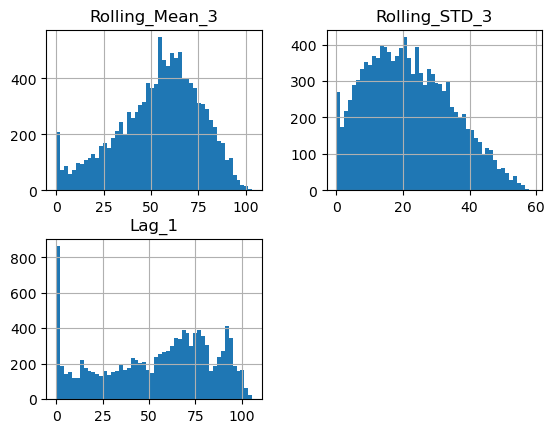

In [101]:
# fill Lag_1, Rolling_Mean_3 with mean
train['Lag_1'].fillna(train['Lag_1'].mean(), inplace=True)
train['Rolling_Mean_3'].fillna(train['Rolling_Mean_3'].mean(), inplace=True)

# fill Rolling_STD_3 with median
train['Rolling_STD_3'].fillna(train['Rolling_STD_3'].median(), inplace=True)

train[cols].hist(bins=50)

<Axes: >

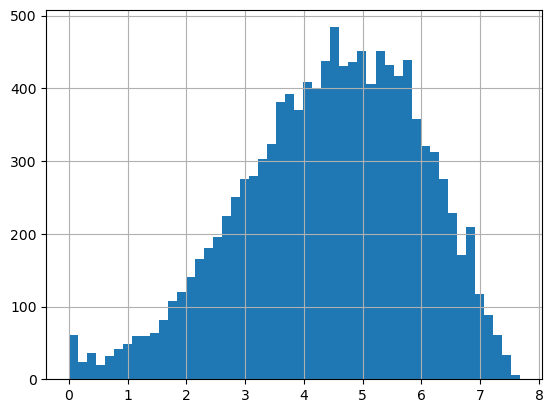

In [106]:
np.sqrt(train['Rolling_STD_3']).hist(bins=50)

In [102]:
train.isna().sum().sort_values(ascending=False)

Country           0
Year              0
Month             0
FoodPriceIndex    0
Date              0
DayOfYear         0
WeekOfYear        0
Quarter           0
Month_Sin         0
Month_Cos         0
Lag_1             0
Rolling_Mean_3    0
Rolling_STD_3     0
Year_Month        0
dtype: int64

In [103]:
train.columns

Index(['Country', 'Year', 'Month', 'FoodPriceIndex', 'Date', 'DayOfYear',
       'WeekOfYear', 'Quarter', 'Month_Sin', 'Month_Cos', 'Lag_1',
       'Rolling_Mean_3', 'Rolling_STD_3', 'Year_Month'],
      dtype='object')

In [107]:
# remove columns
remove_cols = ['Month', 'Date']

train.drop(remove_cols, axis=1, inplace=True)
train.head()

,Country,Year,FoodPriceIndex,DayOfYear,WeekOfYear,Quarter,Month_Sin,Month_Cos,Lag_1,Rolling_Mean_3,Rolling_STD_3,Year_Month
0,11,1971,0.0,305,44,4,-0.500000,0.866025,54.131131,54.136958,20.804647,21681
1,14,2002,43.9,182,27,3,-0.500000,-0.866025,54.131131,54.136958,20.804647,14014
2,9,2004,89.8,214,31,3,-0.866025,-0.500000,54.131131,54.136958,20.804647,16032
3,4,1983,48.9,1,52,1,0.500000,0.866025,54.131131,54.136958,20.804647,1983
4,9,2004,90.2,92,14,2,0.866025,-0.500000,89.800000,54.136958,20.804647,8016


## Modelling

In [116]:
# Calculate sMAPE
def smape(A, F):
    denominator = np.abs(A) + np.abs(F)
    numerator = 2 * np.abs(F - A)
    # print(f"Denominator: {denominator}")
    # print(f"Numerator: {numerator}")
    return 100/len(A) * np.sum(numerator / denominator)

In [137]:
from sklearn.model_selection import train_test_split

X = train.drop('FoodPriceIndex', axis=1)
y = train['FoodPriceIndex']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_val.shape

((9292, 11), (2324, 11))

In [138]:
# Train the ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor

extra_model = ExtraTreesRegressor(n_estimators=100, random_state=0)

extra_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_extra = extra_model.predict(X_val)

# Calculate and print the sMAPE score
score = smape(y_val, y_pred_extra)
print(f'sMAPE score: {score:.2f}')

sMAPE score: 24.91


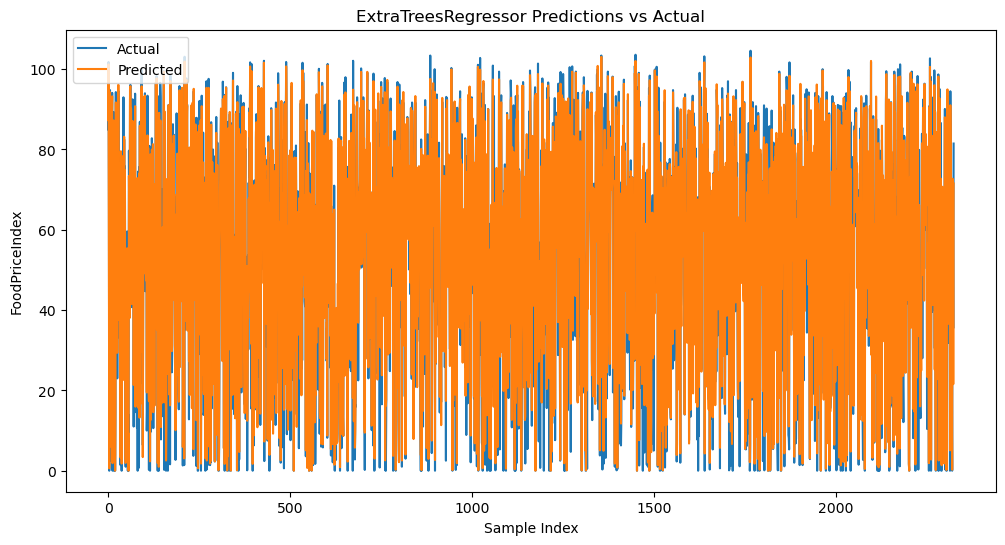

In [139]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_val.reset_index(drop=True).values, label='Actual')
plt.plot(y_pred_extra, label='Predicted')
plt.title('ExtraTreesRegressor Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('FoodPriceIndex')
plt.legend()
plt.show()

In [140]:
# Train the ExtraTreesRegressor

from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=0)

rfr.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = rfr.predict(X_val)

# Calculate and print the sMAPE score
score = smape(y_val, y_pred_rf)
print(f'sMAPE score: {score:.2f}')

sMAPE score: 16.09


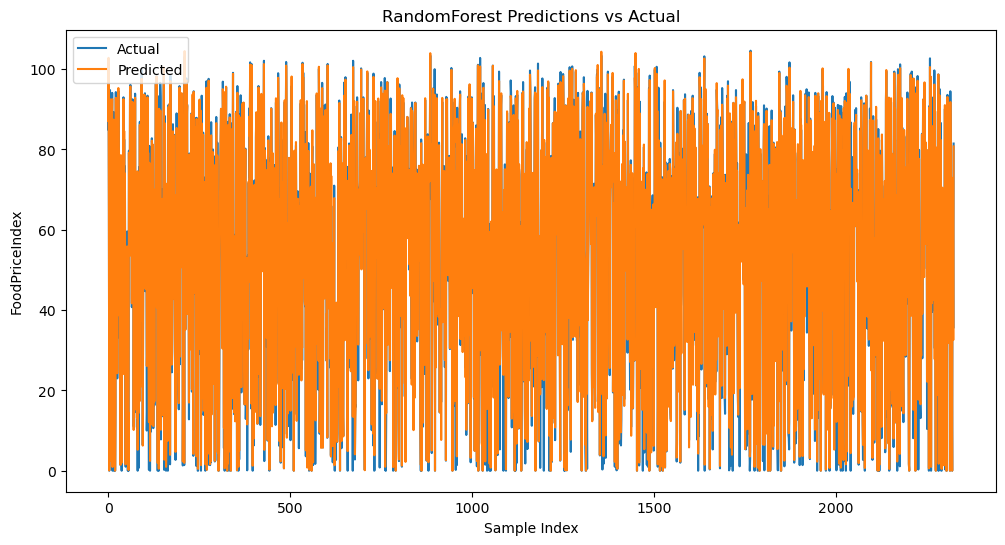

In [141]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.reset_index(drop=True).values, label='Actual')
plt.plot(y_pred_rf, label='Predicted')
plt.title('RandomForest Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('FoodPriceIndex')
plt.legend()
plt.show()

Epoch 1/50
146/146 [==============================] - 2s 4ms/step - loss: 0.1102 - val_loss: 0.0459
Epoch 2/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0235
Epoch 3/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0206 - val_loss: 0.0185
Epoch 4/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0189 - val_loss: 0.0179
Epoch 5/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0184 - val_loss: 0.0175
Epoch 6/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 0.0173
Epoch 7/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0179 - val_loss: 0.0172
Epoch 8/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.0170
Epoch 9/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 10/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0175 - val_loss: 0.0166

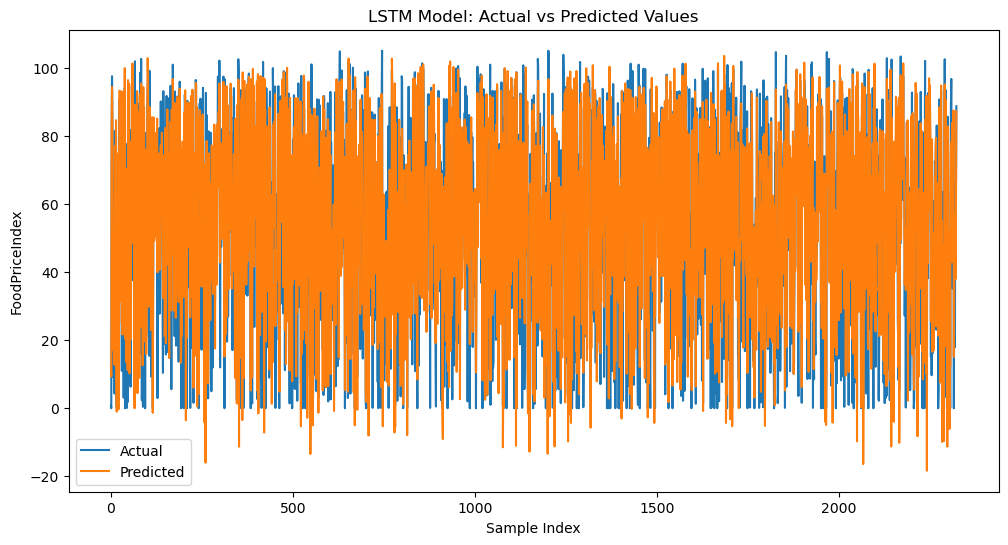

In [142]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming 'train' is your DataFrame
# Select features and target
features = ['Year', 'Month_Sin', 'Month_Cos', 'Lag_1', 'Rolling_Mean_3', 'Rolling_STD_3']
target = 'FoodPriceIndex'

# Prepare the data
data = train[features + [target]].dropna()

# Scale the features and target
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split features and target
X = scaled_data[:, :-1]
y = scaled_data[:, -1]

# Reshape X to fit LSTM input shape [samples, timesteps, features]
timesteps = 1  # Number of time steps; adjust as needed
X_reshaped = X.reshape((X.shape[0], timesteps, X.shape[1]))

# Split data into training and validation sets
train_size = int(len(X_reshaped) * 0.8)
X_train, X_val = X_reshaped[:train_size], X_reshaped[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1)

# Make predictions
y_pred = model.predict(X_val)

# Inverse transform the predictions and actual values
X_val_flat = X_val.reshape((X_val.shape[0], X_val.shape[2]))
y_pred_inv = scaler.inverse_transform(np.hstack((X_val_flat, y_pred)))[:, -1]
y_val_inv = scaler.inverse_transform(np.hstack((X_val_flat, y_val.reshape(-1, 1))))[:, -1]

# Calculate sMAPE
def smape(y_true, y_pred, epsilon=1e-10):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon))

smape_error = smape(y_val_inv, y_pred_inv)
print(f'sMAPE: {smape_error:.2f}%')

# Visualize the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_val_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM Model: Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('FoodPriceIndex')
plt.legend()
plt.show()

In [143]:
train

,Country,Year,FoodPriceIndex,DayOfYear,WeekOfYear,Quarter,Month_Sin,Month_Cos,Lag_1,Rolling_Mean_3,Rolling_STD_3,Year_Month
0,11,1971,0.0000,305,44,4,-5.000000e-01,8.660254e-01,54.131131,54.136958,20.804647,21681
1,14,2002,43.9000,182,27,3,-5.000000e-01,-8.660254e-01,54.131131,54.136958,20.804647,14014
2,9,2004,89.8000,214,31,3,-8.660254e-01,-5.000000e-01,54.131131,54.136958,20.804647,16032
3,4,1983,48.9000,1,52,1,5.000000e-01,8.660254e-01,54.131131,54.136958,20.804647,1983
4,9,2004,90.2000,92,14,2,8.660254e-01,-5.000000e-01,89.800000,54.136958,20.804647,8016
...,...,...,...,...,...,...,...,...,...,...,...,...
11611,16,1974,17.9000,152,22,2,1.224647e-16,-1.000000e+00,75.000000,80.433333,11.187642,11844
11612,5,1987,66.1407,91,14,2,8.660254e-01,-5.000000e-01,81.392100,72.279213,10.400360,7948
11613,5,1974,45.1606,213,31,3,-8.660254e-01,-5.000000e-01,66.140700,74.009780,7.637343,15792
11614,2,1994,65.6000,244,35,3,-1.000000e+00,-1.836970e-16,70.600000,55.866667,19.540812,17946


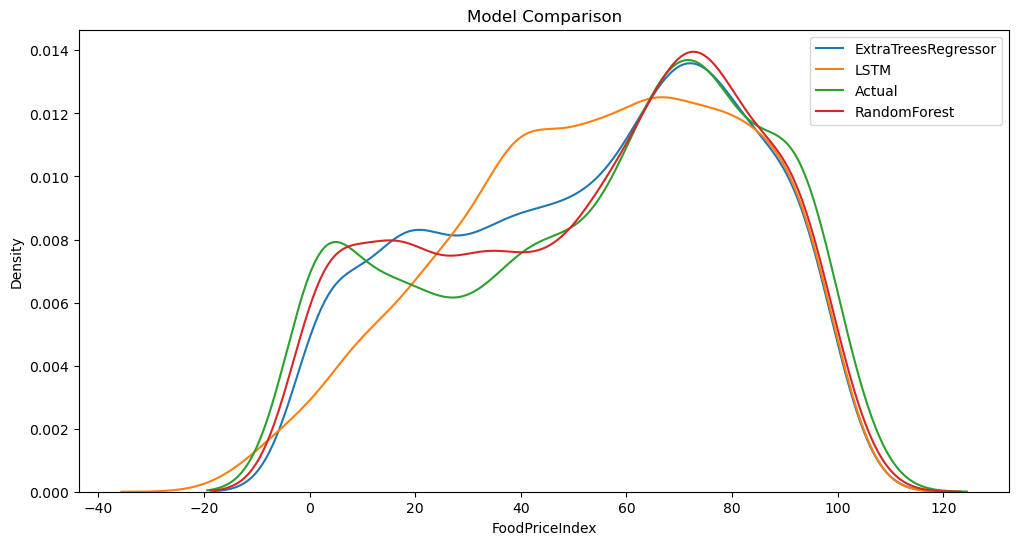

In [145]:
plt.figure(figsize=(12, 6))

# visualize the models comparison
sns.kdeplot(y_pred_extra, label='ExtraTreesRegressor')
sns.kdeplot(y_pred_inv, label='LSTM')
sns.kdeplot(y_val_inv, label='Actual')
sns.kdeplot(y_pred_rf, label='RandomForest')
plt.title('Model Comparison')
plt.xlabel('FoodPriceIndex')
plt.ylabel('Density')
plt.legend()
plt.show()

